In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline


Using TensorFlow backend.


In [2]:
# df = pd.read_csv('data/eth_data.csv')
# df.drop(['Coin'], 1, inplace=True)
# df[["Open", "High", "Low", "Close", "Volume", "Market Cap", "200_MA", "150_MA", "50_MA", "52W_High", "52W_Low", "Volatility"]] = df[["Open", "High", "Low", "Close", "Volume", "Market Cap", "200_MA", "150_MA", "50_MA", "52W_High", "52W_Low", "Volatility"]].apply(pd.to_numeric)
# df = df[::-1]
# df.head(7)
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ETH&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'low'
hist.drop(['conversionType'], 1, inplace=True)
hist.drop(['conversionSymbol'], 1, inplace=True)
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2015-10-30,1.343,0.9365,1.1640,1918765.10,1.993469e+06,1.0390
2015-10-31,1.012,0.8743,1.0390,542320.19,4.842635e+05,0.8929
2015-11-01,1.072,0.8968,0.8929,466656.61,4.899477e+05,1.0500
2015-11-02,1.206,0.9377,1.0500,1004673.98,9.684537e+05,0.9639
2015-11-03,1.159,0.8826,0.9639,1822122.38,1.814080e+06,0.9956
...,...,...,...,...,...,...
2021-04-17,2496.710,2315.7600,2425.9600,439527.77,1.057642e+09,2318.0100
2021-04-18,2339.370,1976.7100,2318.0100,1237429.53,2.686888e+09,2240.9600
2021-04-19,2281.080,2071.5400,2240.9600,712383.89,1.554225e+09,2163.3600


In [3]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(hist, test_size=0.2)

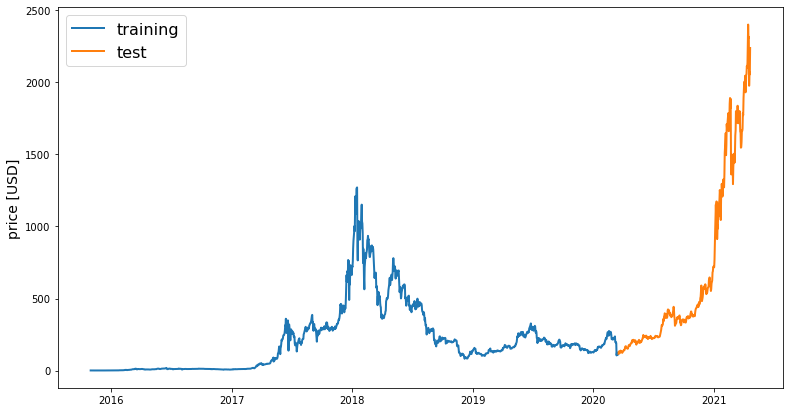

In [4]:
# Plotting The training vs Test data
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')


In [5]:
#Normalizing Data based on Min and Max
def normalise_zero_base(df):
    return df / df.iloc[0] - 1
def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [6]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    
    return np.array(window_data)

In [7]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

In [8]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [24]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [25]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
1596/1596 [==============================] - 0s 306us/step - loss: 0.0119
Epoch 2/20
1596/1596 [==============================] - 0s 125us/step - loss: 0.0081
Epoch 3/20
1596/1596 [==============================] - 0s 121us/step - loss: 0.0069
Epoch 4/20
1596/1596 [==============================] - 0s 125us/step - loss: 0.0065
Epoch 5/20
1596/1596 [==============================] - 0s 125us/step - loss: 0.0060
Epoch 6/20
1596/1596 [==============================] - 0s 125us/step - loss: 0.0053
Epoch 7/20
1596/1596 [==============================] - 0s 131us/step - loss: 0.0053
Epoch 8/20
1596/1596 [==============================] - 0s 121us/step - loss: 0.0048
Epoch 9/20
1596/1596 [==============================] - 0s 120us/step - loss: 0.0047
Epoch 10/20
1596/1596 [==============================] - 0s 118us/step - loss: 0.0049
Epoch 11/20
1596/1596 [==============================] - 0s 125us/step - loss: 0.0043
Epoch 12/20
1596/1596 [==============================] - 0s 122

In [27]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.03090649749763261

In [28]:
test

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-03-18,119.30,116.98,116.20,3527675.95,4.183829e+08,118.60
2020-03-19,138.67,132.91,118.60,3929460.13,5.375877e+08,136.81
2020-03-20,140.89,127.48,136.81,4153651.53,5.537413e+08,133.31
2020-03-21,133.70,130.85,133.31,2702792.47,3.590120e+08,132.83
2020-03-22,125.42,121.17,132.83,2528867.43,3.098058e+08,122.51
...,...,...,...,...,...,...
2021-04-17,2496.71,2315.76,2425.96,439527.77,1.057642e+09,2318.01
2021-04-18,2339.37,1976.71,2318.01,1237429.53,2.686888e+09,2240.96
2021-04-19,2281.08,2071.54,2240.96,712383.89,1.554225e+09,2163.36


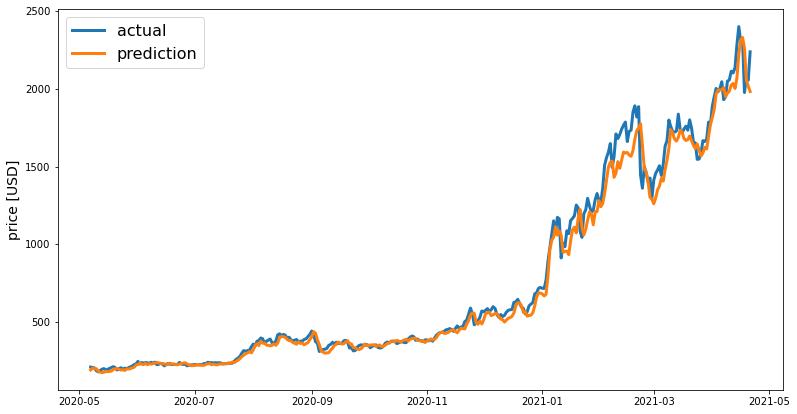

In [23]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

IndexError: list index out of range